In [1]:
! source ../venv/bin/activate

In [2]:
! which python

/Users/JMECKEL/development/projects/python/udacity_boarding_kiosk/venv/bin/python


In [3]:
import sys
print(sys.executable)

/Users/JMECKEL/development/projects/python/udacity_boarding_kiosk/venv/bin/python


In [4]:
import uuid
from azure.cognitiveservices.vision.customvision.training import CustomVisionTrainingClient
from azure.cognitiveservices.vision.customvision.prediction import CustomVisionPredictionClient
from azure.cognitiveservices.vision.customvision.training.models import ImageFileCreateBatch, ImageFileCreateEntry, Region
from azure.core.credentials import AzureKeyCredential
from msrest.authentication import ApiKeyCredentials

from azure.storage.blob import ContainerClient
from pdf2image import convert_from_path
from PIL import Image
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import os
import time

In [5]:
load_dotenv(dotenv_path="../.env", override=True)

CUSTOM_VISION_PREDICTION_RESOURCE_ID = os.getenv("CUSTOM_VISION_PREDICTION_RESOURCE_ID")
CUSTOM_VISION_RESOURCE_ID = os.getenv("CUSTOM_VISION_RESOURCE_ID")
CUSTOM_VISION_ENDPOINT = os.getenv("CUSTOM_VISION_ENDPOINT")
CUSTOM_VISION_KEY = os.getenv("CUSTOM_VISION_KEY")
CUSTOM_VISION_PREDICTION_ENDPOINT = os.getenv("CUSTOM_VISION_PREDICTION_ENDPOINT")
CUSTOM_VISION_PREDICTION_KEY = os.getenv("CUSTOM_VISION_PREDICTION_KEY")

In [6]:
!ls -al ../starter/boarding_pass_template/

total 1432
drwxr-xr-x@ 10 JMECKEL  staff     320 Jul 15 15:14 .
drwxr-xr-x@ 20 JMECKEL  staff     640 Jul 15 15:28 ..
-rw-r--r--@  1 JMECKEL  staff   35277 Jul 15 15:14 boarding_pass_template.docx
-rw-r--r--@  1 JMECKEL  staff  116384 Jul 15 15:14 boarding_pass_template.pdf
-rw-r--r--@  1 JMECKEL  staff   94851 Jul 15 15:14 boarding-avkash.pdf
-rw-r--r--@  1 JMECKEL  staff   94718 Jul 15 15:14 boarding-james-webb.pdf
-rw-r--r--@  1 JMECKEL  staff   94115 Jul 15 15:14 boarding-james.pdf
-rw-r--r--@  1 JMECKEL  staff   94842 Jul 15 15:14 boarding-libby.pdf
-rw-r--r--@  1 JMECKEL  staff   93823 Jul 15 15:14 boarding-radha-s-kumar.pdf
-rw-r--r--@  1 JMECKEL  staff   93262 Jul 15 15:14 boarding-sameer.pdf


In [7]:
training_credentials = ApiKeyCredentials(in_headers={"Training-key": CUSTOM_VISION_KEY})
trainer = CustomVisionTrainingClient(CUSTOM_VISION_ENDPOINT, training_credentials)
trainer.api_version

'3.4-preview'

In [8]:
project_id = "972087ed-1ad7-4e75-a45e-14c4a0eb52e4"

In [9]:
existing_tags = trainer.get_tags(project_id)
lighter_tag = next((tag for tag in existing_tags if tag.name == "lighter"), None)

# Create the tag only if it doesn't exist
if lighter_tag is None:
    lighter_tag = trainer.create_tag(project_id, "lighter")

In [10]:
iteration = trainer.train_project(project_id, force_train=True)
while (iteration.status != "Completed"):
    iteration = trainer.get_iteration(project_id, iteration.id)
    print ("Training status: " + iteration.status)
    print ("Waiting 10 seconds...")
    time.sleep(10)



Training status: Training
Waiting 10 seconds...
Training status: Training
Waiting 10 seconds...
Training status: Training
Waiting 10 seconds...
Training status: Training
Waiting 10 seconds...
Training status: Training
Waiting 10 seconds...
Training status: Training
Waiting 10 seconds...
Training status: Training
Waiting 10 seconds...
Training status: Training
Waiting 10 seconds...
Training status: Training
Waiting 10 seconds...
Training status: Training
Waiting 10 seconds...
Training status: Training
Waiting 10 seconds...
Training status: Training
Waiting 10 seconds...
Training status: Training
Waiting 10 seconds...
Training status: Training
Waiting 10 seconds...
Training status: Training
Waiting 10 seconds...
Training status: Training
Waiting 10 seconds...
Training status: Training
Waiting 10 seconds...
Training status: Training
Waiting 10 seconds...
Training status: Training
Waiting 10 seconds...
Training status: Training
Waiting 10 seconds...
Training status: Training
Waiting 10 sec

In [13]:
iteration.as_dict()
iteration_list = trainer.get_iterations(project_id)
for iteration_item in iteration_list:
    if iteration_item.publish_name:  # Only unpublish if published
        trainer.unpublish_iteration(project_id, iteration_item.id)
    created = iteration_item.created
    last_modified = iteration_item.last_modified
    print(f"{iteration_item.id}, {iteration_item.name}, {iteration_item.status}, created {created}, last_modified {last_modified}")
    print("--------------------------------------------------")
print(f"using {iteration_list[0].id} {iteration_list[0].name}")

model_perf = trainer.get_iteration_performance(project_id, iteration_list[0].id)
model_perf.as_dict()

aeb2fe1d-ded1-4f96-a77c-c8ad5b5d86c5, Iteration 7, Completed, created 2025-07-17 09:19:00.276000+00:00, last_modified 2025-07-17 09:52:10.860000+00:00
--------------------------------------------------
87340f2d-806e-481a-bd79-988d647a27d6, Iteration 6, Completed, created 2025-07-17 09:03:09.723000+00:00, last_modified 2025-07-17 09:23:22.553000+00:00
--------------------------------------------------
514d5a07-280a-451f-835f-e1ca4119204b, Iteration 5, Completed, created 2025-07-17 08:14:07.866000+00:00, last_modified 2025-07-17 10:12:03.376000+00:00
--------------------------------------------------
92f6a5e2-9c43-430a-b1da-a21fb076fcf2, Iteration 4, Completed, created 2025-07-17 07:59:21.546000+00:00, last_modified 2025-07-17 08:57:49.452000+00:00
--------------------------------------------------
74e8e252-e079-444c-bfc7-b4814a9ec497, Iteration 3, Completed, created 2025-07-17 07:54:41.283000+00:00, last_modified 2025-07-17 08:03:45.557000+00:00
-----------------------------------------

{'per_tag_performance': [{'id': '0d6f4a36-a949-4ced-9333-6dcf45f13a92',
   'name': 'lighter',
   'precision': 0.85714287,
   'precision_std_deviation': 0.0,
   'recall': 0.4,
   'recall_std_deviation': 0.0,
   'average_precision': 0.60161877}],
 'precision': 0.85714287,
 'precision_std_deviation': 0.0,
 'recall': 0.4,
 'recall_std_deviation': 0.0,
 'average_precision': 0.60161877}

In [14]:
publish_iteration_name = "udacity-jmeckel-lighter-detection"
# The iteration is now trained. Publish it to the project endpoint
trainer.publish_iteration(project_id, iteration_list[0].id, publish_iteration_name, CUSTOM_VISION_PREDICTION_RESOURCE_ID)
print("Done!")

Done!


In [15]:
prediction_url = f"{CUSTOM_VISION_PREDICTION_ENDPOINT}/customvision/v3.0/Prediction/{project_id}/detect/iterations/{publish_iteration_name}/image"

In [16]:
test_image_path = "../starter/lighter_test_images"

In [17]:
prediction_credentials = ApiKeyCredentials(in_headers={"Prediction-key": CUSTOM_VISION_PREDICTION_KEY})
predictor = CustomVisionPredictionClient(CUSTOM_VISION_PREDICTION_ENDPOINT, prediction_credentials)

In [18]:
def perform_prediction(image_file_name):
    with open(os.path.join (test_image_path,  image_file_name), "rb") as image_contents:
        results = predictor.detect_image(project_id, publish_iteration_name, image_contents.read())
        # Display the results.
        for prediction in results.predictions:
            print("\t" + prediction.tag_name +
                  ": {0:.2f}%".format(prediction.probability * 100))


lighter_test_set_5of5.jpg


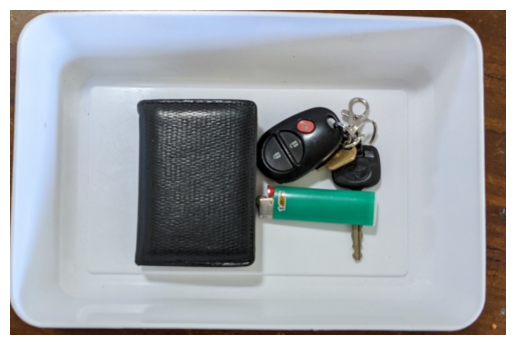

	lighter: 98.24%
	lighter: 24.43%
	lighter: 12.88%

lighter_test_set_3of5.jpg


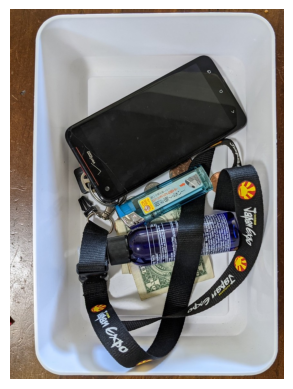

	lighter: 55.84%
	lighter: 2.01%
	lighter: 1.55%

lighter_test_set_1of5.jpg


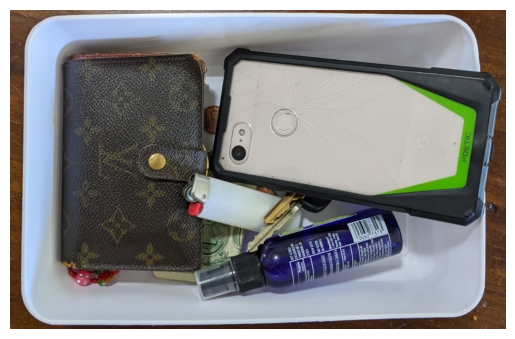

	lighter: 96.13%
	lighter: 24.63%
	lighter: 17.76%
	lighter: 2.95%

lighter_test_set_4of5.jpg


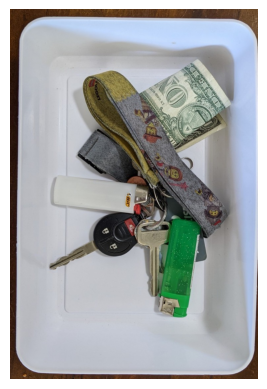

CustomVisionErrorException: Operation returned an invalid status code 'Too Many Requests'

In [19]:
for file_name in os.listdir(test_image_path):
    file_path = os.path.join(test_image_path, file_name)
    if os.path.isfile(file_path):
        print(f"\n{file_name}")
        with open(file_path, 'rb') as img_code:
            img_view_ready = Image.open(img_code)
            plt.figure()
            plt.imshow(img_view_ready)
            plt.axis('off')
            plt.show()
        perform_prediction(file_name)
